In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# Clean the data

# Drop rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPurchaseAmount column
df['TotalPurchaseAmount'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Sort by InvoiceDate (optional but neat)
df = df.sort_values(by='InvoiceDate')

# Save cleaned data
df.to_csv('cleaned_data.csv', index=False)

# Display few cleaned rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchaseAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
import datetime as dt

# Reference date for Recency (e.g., the day after the last purchase in dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPurchaseAmount': 'sum'                               # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Save for clustering step
rfm.to_csv('rfm_data.csv', index=False)

# Display sample RFM data
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [8]:
from sklearn.preprocessing import StandardScaler

# Copy RFM for clustering
rfm_model = rfm.copy()

# Features to scale
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()

# Fit and transform
rfm_scaled = scaler.fit_transform(rfm_model[features])


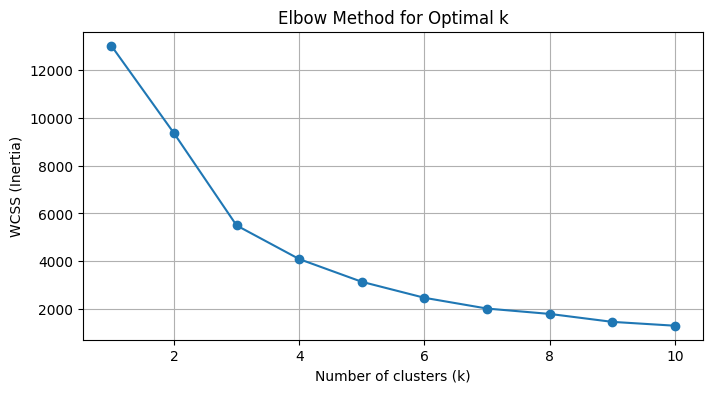

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
wcss = []

# Try different numbers of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid()
plt.show()


In [11]:
# KMeans clustering
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm_model['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View segmented data
rfm_model.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [12]:
# Cluster summary
rfm_summary = rfm_model.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

print(rfm_summary)


            Recency  Frequency       Monetary  Num_Customers
Cluster                                                     
0         43.702685   3.682711    1359.049284           3054
1        248.075914   1.552015     480.617480           1067
2          7.384615  82.538462  127338.313846             13
3         15.500000  22.333333   12709.090490            204


In [16]:
df.to_csv("clustered_customers.csv", index=False)
clustered=pd.read_csv("clustered_customers.csv")
clustered.head() # Display few rows of clustered data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchaseAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
from datetime import datetime

# Snapshot date = 1 day after the latest purchase
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


In [18]:
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPurchaseAmount': 'sum'                              # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [22]:
rfm_df.to_csv('rfm_clustered_customers.csv', index=False)
print("✅ Saved rfm_clustered_customers.csv successfully!")
rfm=pd.read_csv('rfm_clustered_customers.csv')
rfm.head() # Display few rows of clustered data


✅ Saved rfm_clustered_customers.csv successfully!


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


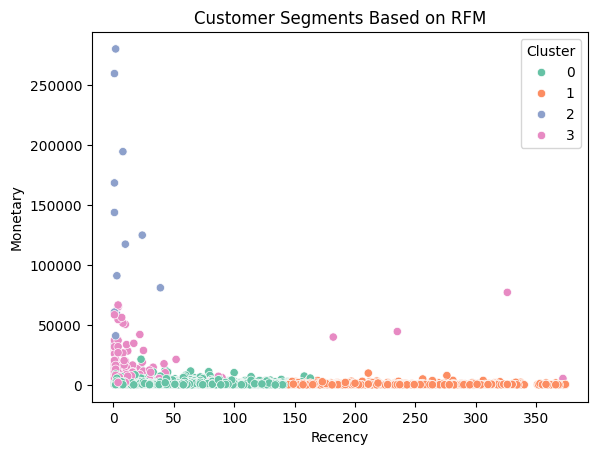

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments Based on RFM')
plt.show()
